# Importing all libraries

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input, Dropout, Embedding, LSTM
from tensorflow.keras.optimizers import RMSprop, Adam, Nadam
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import TensorBoard
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score, classification_report
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Loading our pre processed data 

In [64]:
combined = pd.read_csv('combined_leaks.csv', sep=',')

In [70]:
combined.dtypes

UTC_TIME               object
FUEL_USED_2           float64
FUEL_USED_3           float64
FUEL_USED_4           float64
FW_GEO_ALTITUDE       float64
VALUE_FOB             float64
VALUE_FUEL_QTY_CT     float64
VALUE_FUEL_QTY_FT1    float64
VALUE_FUEL_QTY_FT2    float64
VALUE_FUEL_QTY_FT3    float64
VALUE_FUEL_QTY_FT4    float64
VALUE_FUEL_QTY_LXT    float64
VALUE_FUEL_QTY_RXT    float64
FLIGHT_PHASE_COUNT    float64
FUEL_USED_1           float64
Flight                float64
MSN                    object
dtype: object

In [71]:
combined.dropna(inplace=True)

In [74]:
df = combined

In [75]:
df.dropna(inplace=True)

# Showing the number of flights with leakages

We are displayin the number of flights we inserted leakages into. We inserted 100 leakages into 479 flights so roughly 20%.

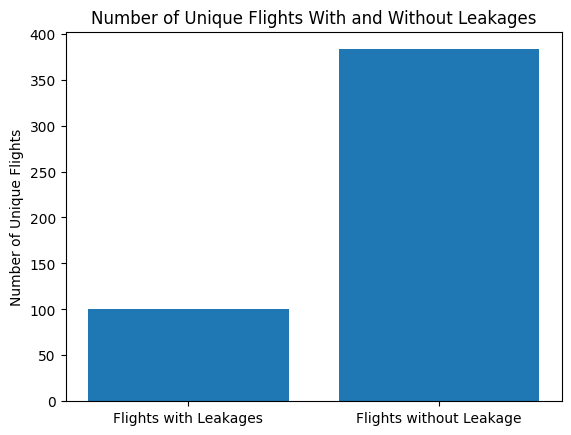

In [ ]:
# Get unique flight names that contain 'L'
unique_L_flights = len([flight for flight in df['Flight'].unique() if 'L' in str(flight)])

# Get unique flight names that don't contain 'L'
unique_non_L_flights = len([flight for flight in df['Flight'].unique() if 'L' not in str(flight)])

# Create a bar plot
plt.bar(['Flights with Leakages', 'Flights without Leakage'], [unique_L_flights, unique_non_L_flights])
plt.ylabel('Number of Unique Flights')
plt.title('Number of Unique Flights With and Without Leakages')
plt.show()

# Splitting the data into train,test by date so all flights are kept together. we split it roughly 75 - 25

In [ ]:
# Select a split point
split_date = '2018-02-01'  # Example split date

# Split the data into train and test sets
train_df = df[df['UTC_TIME'] < split_date]
test_df = df[df['UTC_TIME'] >= split_date]

# Display the shapes of the resulting dataframes
print(f'Training data shape: {train_df.shape}')
print(f'Testing data shape: {test_df.shape}')

Training data shape: (280539, 33)
Testing data shape: (94288, 33)


In [ ]:
#Count the number of flights with L in their name in Train and Test
train_L_flights = len([flight for flight in train_df['Flight'].unique() if 'L' in str(flight)])
test_L_flights = len([flight for flight in test_df['Flight'].unique() if 'L' in str(flight)])

#Print the 2 numbers to compare
print(f'Number of flights with Leakage in their name in Train: {train_L_flights}')
print(f'Number of flights with Leakage in their name in Test: {test_L_flights}')

Number of flights with Leakage in their name in Train: 92
Number of flights with Leakage in their name in Test: 15


# Autoencoders

In [88]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from keras.models import Model
from keras.layers import Input, Dense
from keras import regularizers
import numpy as np

# Assuming 'df' and 'test_df' are DataFrames containing the datasets

# Filter out the entries with leaks from training data
train_data = df[df['Leaks'] == 0].drop(columns=['Leaks'])

# Normalize the training data using Min-Max scaling
scaler = MinMaxScaler()
train_data_scaled = scaler.fit_transform(train_data)

# Define the autoencoder model architecture
input_dim = train_data_scaled.shape[1]  # Number of features
encoding_dim = 14  # Dimension of the encoded representation

# Input layer
input_layer = Input(shape=(input_dim,))
# Encoder layers
encoder = Dense(encoding_dim, activation="tanh", activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)
# Decoder layers
decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)

# Define the autoencoder model
autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

# Train the autoencoder on the scaled training data
autoencoder.fit(train_data_scaled, train_data_scaled,
                epochs=100,
                batch_size=32,
                shuffle=True,
                validation_split=0.2,
                verbose=1)

# Prepare the test data by dropping 'Leaks' column and scaling
test_data = test_df.drop(columns=['Leaks'])
test_data_scaled = scaler.transform(test_data)

# Get the reconstruction loss (MSE) on the test data
reconstructions = autoencoder.predict(test_data_scaled)
mse = np.mean(np.power(test_data_scaled - reconstructions, 2), axis=1)

# Determine the threshold for anomaly detection based on 95th percentile of MSE
threshold = np.percentile(mse, 95)

# Detect anomalies based on the threshold
test_df['reconstruction_error'] = mse
test_df['anomaly'] = test_df['reconstruction_error'] > threshold

# Calculate evaluation metrics: Confusion Matrix, Accuracy, Precision, Recall, F1 Score
y_true = test_df['Leaks']  # True labels
y_pred = test_df['anomaly'].astype(int)  # Predicted labels (0 or 1)

conf_matrix = confusion_matrix(y_true, y_pred)  # Confusion Matrix
accuracy = accuracy_score(y_true, y_pred)  # Accuracy
precision = precision_score(y_true, y_pred)  # Precision
recall = recall_score(y_true, y_pred)  # Recall
f1 = f1_score(y_true, y_pred)  # F1 Score

# Print the evaluation results
print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 12)             │            24 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1)              │            13 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 37 (148.00 B)

 Trainable params: 37 (148.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
46064/46064 ━━━━━━━━━━━━━━━━━━━━ 13s 268us/step - loss: 0.1823 - val_loss: 5.1731
Epoch 2/50
46064/46064 ━━━━━━━━━━━━━━━━━━━━ 12s 266us/step - loss: 0.1790 - val_loss: 5.1717
Epoch 3/50
46064/46064 ━━━━━━━━━━━━━━━━━━━━ 12s 268us/step - loss: 0.1788 - val_loss: 5.1704
Epoch 4/50
46064/46064 ━━━━━━━━━━━━━━━━━━━━ 12s 269us/step - loss: 0.1787 - val_loss: 5.1699
Epoch 5/50
46064/46064 ━━━━━━━━━━━━━━━━━━━━ 12s 268us/step - loss: 0.1787 - val_loss: 5.1697
Epoch 6/50
46064/46064 ━━━━━━━━━━━━━━━━━━━━ 12s 270us/step - loss: 0.1787 - val_loss: 5.1696
Epoch 7/50
46064/46064 ━━━━━━━━━━━━━━━━━━━━ 12s 269us/step - loss: 0.1787 - val_loss: 5.1696
Epoch 8/50
46064/46064 ━━━━━━━━━━━━━━━━━━━━ 12s 269us/step - loss: 0.1787 - val_loss: 5.1696
Epoch 9/50
46064/46064 ━━━━━━━━━━━━━━━━━━━━ 12s 270us/step - loss: 0.1787 - val_loss: 5.1694
Epoch 10/50
46064/46064 ━━━━━━━━━━━━━━━━━━━━ 12s 268us/step - loss: 0.1787 - val_loss: 5.1693
Epoch 11/50
46064/46064 ━━━━━━━━━━━━━━━━━━━━ 13s 271us/step - loss: 0

In [89]:
import tensorflow as tf
from tensorflow.keras import layers

# Define a custom AnomalyDetector class inheriting from tf.keras.Model
class AnomalyDetector(tf.keras.Model):
    def __init__(self):
        super(AnomalyDetector, self).__init__()
        
        # Encoder layers: reduces input dimensions
        self.encoder = tf.keras.Sequential([
            layers.Dense(80, activation="relu"),  # 1st hidden layer with 80 units, ReLU activation
            layers.Dense(70, activation="relu"),  # 2nd hidden layer with 70 units, ReLU activation
            layers.Dense(60, activation="relu"),  # 3rd hidden layer with 60 units, ReLU activation
            layers.Dense(50, activation="relu")   # 4th hidden layer with 50 units, ReLU activation
        ])
        
        # Decoder layers: reconstructs the input
        self.decoder = tf.keras.Sequential([
            layers.Dense(50, activation="relu"),  # 1st hidden layer with 50 units, ReLU activation
            layers.Dense(60, activation="relu"),  # 2nd hidden layer with 60 units, ReLU activation
            layers.Dense(70, activation="relu"),  # 3rd hidden layer with 70 units, ReLU activation
            layers.Dense(80, activation="relu"),  # 4th hidden layer with 80 units, ReLU activation
            layers.Dense(10, activation="sigmoid")  # Output layer with 10 units, sigmoid activation
        ])
    
    # Define the call method to forward pass through the model
    def call(self, x):
        encoded = self.encoder(x)  # Encode the input
        decoded = self.decoder(encoded)  # Decode the encoded representation
        return decoded  # Return the reconstructed input

# Create an instance of the AnomalyDetector model
autoencoder = AnomalyDetector()



In [90]:
# Compile the autoencoder model
autoencoder.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),  # Adam optimizer with a learning rate of 0.001
    loss='mse'  # Mean Squared Error (MSE) loss function
)

In [92]:
# Train the autoencoder model
history = autoencoder.fit(
    train_x,  # Training data (input and output are the same for autoencoder)
    train_x,  # Labels (again, input and output are the same for autoencoder)
    epochs=300,  # Number of epochs (iterations over the entire dataset)
    batch_size=100,  # Number of samples per gradient update
    validation_data=(test_x, test_x),  # Data on which to evaluate the loss and any model metrics at the end of each epoch
    shuffle=True  # Shuffle the training data before each epoch
)


Epoch 1/300


4607/4607 ━━━━━━━━━━━━━━━━━━━━ 5s 745us/step - loss: 0.8551 - val_loss: 5.1665
Epoch 2/300
4607/4607 ━━━━━━━━━━━━━━━━━━━━ 3s 722us/step - loss: 0.8268 - val_loss: 5.1665
Epoch 3/300
4607/4607 ━━━━━━━━━━━━━━━━━━━━ 3s 726us/step - loss: 0.8357 - val_loss: 5.1665
Epoch 4/300
4607/4607 ━━━━━━━━━━━━━━━━━━━━ 4s 791us/step - loss: 0.8403 - val_loss: 5.1665
Epoch 5/300
4607/4607 ━━━━━━━━━━━━━━━━━━━━ 4s 780us/step - loss: 0.8353 - val_loss: 5.1665
Epoch 6/300
4607/4607 ━━━━━━━━━━━━━━━━━━━━ 4s 760us/step - loss: 0.8392 - val_loss: 5.1665
Epoch 7/300
4607/4607 ━━━━━━━━━━━━━━━━━━━━ 4s 788us/step - loss: 0.8358 - val_loss: 5.1665
Epoch 8/300
4607/4607 ━━━━━━━━━━━━━━━━━━━━ 4s 775us/step - loss: 0.8323 - val_loss: 5.1665
Epoch 9/300
4607/4607 ━━━━━━━━━━━━━━━━━━━━ 4s 778us/step - loss: 0.8476 - val_loss: 5.1665
Epoch 10/300
4607/4607 ━━━━━━━━━━━━━━━━━━━━ 4s 786us/step - loss: 0.8450 - val_loss: 5.1665
Epoch 11/300
4607/4607 ━━━━━━━━━━━━━━━━━━━━ 4s 782us/step - loss: 0.8446 - val_loss: 5.1665
Epoch 12/

In [93]:
# Make predictions using the autoencoder on the test data
test_x_predictions = autoencoder.predict(test_x)

# Calculate the Mean Squared Error (MSE) between original test data and predicted data
mse = np.mean(np.power(test_x - test_x_predictions, 2), axis=1)


5105/5105 ━━━━━━━━━━━━━━━━━━━━ 1s 252us/step


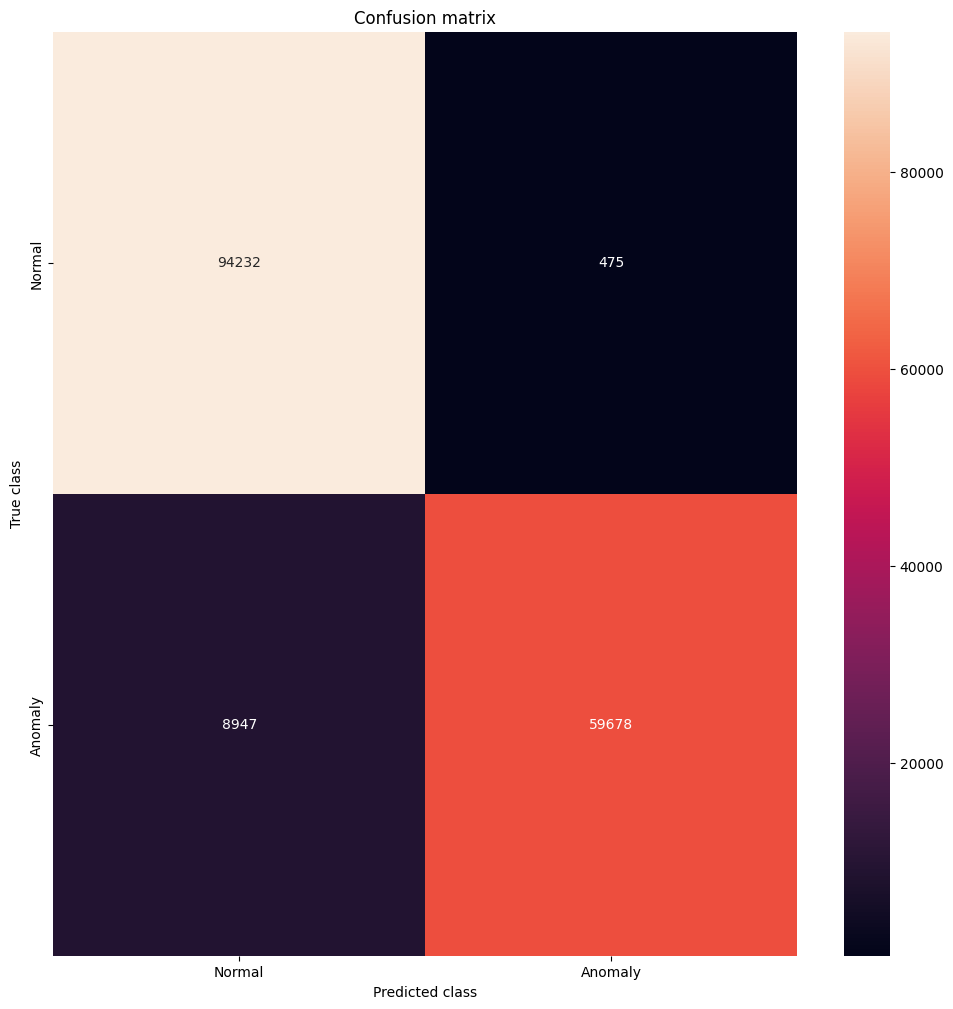

KeyError: "['Flight'] not in index"

In [ ]:
# Score the model
test_x_predictions = autoencoder.predict(test_x)  # Generate predictions using the autoencoder
mse = np.mean(np.power(test_x - test_x_predictions, 2), axis=1)  # Calculate Mean Squared Error (MSE)
error_df = pd.DataFrame({'Reconstruction_error': mse,
                         'True_class': test_df['leak']})  # Create DataFrame with MSE and true classes

error_df.describe()  # Display descriptive statistics of error_df

# Include 'Flight' column when creating error_df DataFrame
error_df = pd.DataFrame({'Reconstruction_error': mse,
                         'True_class': test_df['leak'],
                         'Flight': test_df['flight']})

# Filter for predicted leakages
predicted_leakages = error_df[error_df['True_class'] == 1]

# Print the predicted leakages and the flight they belong to
print(predicted_leakages)

# Group by 'Flight' and count the number of predicted leakages for each flight
predicted_leakages_count = predicted_leakages.groupby('Flight').size()

# Print the result
print(predicted_leakages_count)

# Create confusion matrix
from sklearn.metrics import confusion_matrix

threshold_fixed = 0.6  # Set a fixed threshold for anomaly detection
y_pred = [1 if e > threshold_fixed else 0 for e in error_df.Reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.True_class, y_pred)  # Calculate confusion matrix

plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=['Normal', 'Anomaly'], yticklabels=['Normal', 'Anomaly'], annot=True, fmt="d");
plt.title('Confusion matrix')
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

# Print the flights in which anomalies were detected and how many were detected in those flights
# Include 'Flight' column when creating anomalies DataFrame
anomalies = error_df[error_df['True_class'] == 1][['Flight', 'True_class']]

# Group by 'Flight' and count the number of anomalies for each flight
anomalies_count = anomalies.groupby('Flight').size()

# Print the result
print(anomalies_count)

# Calculate accuracy, recall, precision, and F1 score
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

accuracy = accuracy_score(error_df.True_class, y_pred)
recall = recall_score(error_df.True_class, y_pred)
precision = precision_score(error_df.True_class, y_pred)
f1 = f1_score(error_df.True_class, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Recall: {recall}')
print(f'Precision: {precision}')
print(f'F1 Score: {f1}')

# Print number of flights in which anomalies were detected
print(f'Number of flights in which anomalies were detected: {len(anomalies_count)}')

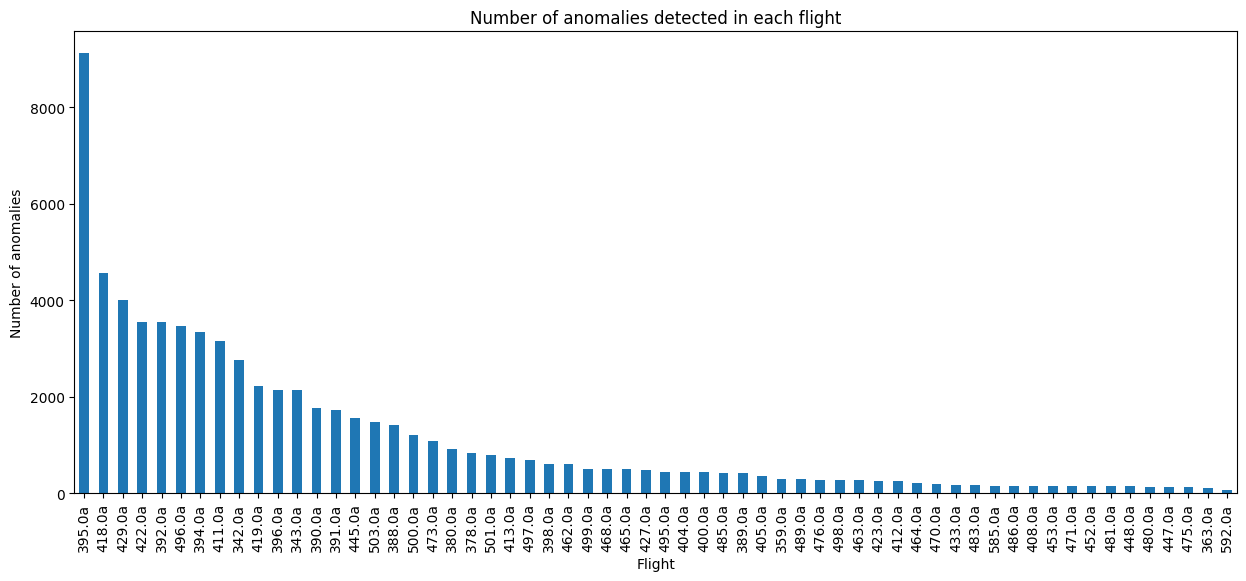

In [ ]:
# Plot the flights with most anomalies from higher to lower
anomalies_count.sort_values(ascending=False).plot(kind='bar', figsize=(15, 6))  # Sort and plot anomalies_count
plt.title('Number of anomalies detected in each flight')  # Set title of the plot
plt.xlabel('Flight')  # Set label for x-axis
plt.ylabel('Number of anomalies')  # Set label for y-axis
plt.show()  # Display the plot

In [ ]:
#save the model
autoencoder.save('autoencoder_model.h5')



# Isolation forest



In [ ]:
#running isolation forest
from sklearn.ensemble import IsolationForest

# Create an Isolation Forest object
isolation_forest = IsolationForest(contamination=0.025)

# Fit the model
isolation_forest.fit(train_x)

# Predict anomalies
train_x_predictions = isolation_forest.predict(train_x)
test_x_predictions = isolation_forest.predict(test_x)

# Convert predictions to binary labels
train_x_predictions = (train_x_predictions == -1).astype(int)
test_x_predictions = (test_x_predictions == -1).astype(int)

# Print the confusion matrix for training data
cm_train = confusion_matrix(train_df['leak'], train_x_predictions)
print(cm_train)

# Print the confusion matrix for test data
cm_test = confusion_matrix(test_df['leak'], test_x_predictions)
print(cm_test)

# Print the number of anomalies detected in each flight
# Include 'Flight' column when creating anomalies DataFrame
anomalies = error_df[error_df['True_class'] == 1][['Flight', 'True_class']]
anomalies_count = anomalies.groupby('Flight').size()
print(anomalies_count)

#print precision, recall, accuracy and f1 score
accuracy = accuracy_score(test_df['leak'], test_x_predictions)
recall = recall_score(test_df['leak'], test_x_predictions)
precision = precision_score(test_df['leak'], test_x_predictions)
f1 = f1_score(test_df['leak'], test_x_predictions)

print(f'Accuracy: {accuracy}')
print(f'Recall: {recall}')
print(f'Precision: {precision}')
print(f'F1 Score: {f1}')



[[281035    811]
 [168555  10236]]
[[89158  5549]
 [30490 38135]]
Flight
342.0a    2759
343.0a    2141
359.0a     310
363.0a     119
378.0a     834
380.0a     918
388.0a    1422
389.0a     414
390.0a    1764
391.0a    1736
392.0a    3556
394.0a    3344
395.0a    9119
396.0a    2145
398.0a     608
400.0a     438
404.0a     441
405.0a     365
408.0a     152
411.0a    3160
412.0a     260
413.0a     740
418.0a    4560
419.0a    2236
422.0a    3558
423.0a     264
427.0a     481
429.0a    4016
433.0a     181
445.0a    1569
447.0a     142
448.0a     146
452.0a     150
453.0a     151
462.0a     604
463.0a     273
464.0a     222
465.0a     497
468.0a     498
470.0a     202
471.0a     150
473.0a    1086
475.0a     137
476.0a     289
480.0a     143
481.0a     146
483.0a     167
485.0a     422
486.0a     154
489.0a     306
495.0a     451
496.0a    3474
497.0a     698
498.0a     281
499.0a     505
500.0a    1216
501.0a     795
503.0a    1491
585.0a     155
592.0a      64
dtype: int64
Accuracy: 0.77

# XGBoost



In [ ]:
xgboostdata = combined[['VALUE_FOB', 'predicted_FOB', 'Real_FOB-predicted_FOB', 'diff_FOB', 'diff_initial_FOB_fuel_used+FOB', 'fuel_used_per_minute_total_fuel_used_diff', 'total_fuel_used', 'flight_entry', 'leak','UTC_TIME']]

In [ ]:
#adding new features to xgboostdata that are rolling means of the column VALUE_FOB
xgboostdata['VALUE_FOB_mean'] = xgboostdata['VALUE_FOB'].rolling(window=10).mean()
xgboostdata['VALUE_FOB_mean'] = xgboostdata['VALUE_FOB_mean'].fillna(xgboostdata['VALUE_FOB_mean'].mean())
xgboostdata['lagged'] = xgboostdata['VALUE_FOB'].shift(1)

/var/folders/6g/x5lm6rt15m9bd1llv55ld0_h0000gn/T/ipykernel_2418/3639962690.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  xgboostdata['VALUE_FOB_mean'] = xgboostdata['VALUE_FOB'].rolling(window=10).mean()
/var/folders/6g/x5lm6rt15m9bd1llv55ld0_h0000gn/T/ipykernel_2418/3639962690.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  xgboostdata['VALUE_FOB_mean'] = xgboostdata['VALUE_FOB_mean'].fillna(xgboostdata['VALUE_FOB_mean'].mean())
/var/folders/6g/x5lm6rt15m9bd1llv55ld0_h0000gn/T/ipykernel_2418/3639

In [ ]:
# Convert 'UTC_TIME' column to datetime type
xgboostdata['UTC_TIME'] = pd.to_datetime(xgboostdata['UTC_TIME'])

# Split the data into train and test
split_date = pd.to_datetime('2018-02-01')
train = xgboostdata[xgboostdata['UTC_TIME'] < split_date]
test = xgboostdata[xgboostdata['UTC_TIME'] >= split_date]

/var/folders/6g/x5lm6rt15m9bd1llv55ld0_h0000gn/T/ipykernel_2418/2722413516.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  xgboostdata['UTC_TIME'] = pd.to_datetime(xgboostdata['UTC_TIME'])


In [ ]:
train = train.drop(columns=['UTC_TIME'])
test = test.drop(columns=['UTC_TIME'])

In [ ]:
target_train = train['leak']
target_test = test['leak']

train = train.drop(columns=['leak'])
test = test.drop(columns=['leak'])

In [ ]:
#using xgboost to detect anomalies
from xgboost import XGBClassifier

# Create an XGBoost classifier object
xgb = XGBClassifier()

# Fit the model
xgb.fit(train, target_train)

# Predict anomalies
train_x_predictions = xgb.predict(train)
test_x_predictions = xgb.predict(test)

# Print the confusion matrix for training data
cm_train = confusion_matrix(target_train, train_x_predictions)
print(cm_train)

# Print the confusion matrix for test data
cm_test = confusion_matrix(target_test, test_x_predictions)
print(cm_test)

# Print the number of anomalies detected in each flight
# Include 'Flight' column when creating anomalies DataFrame
anomalies = error_df[error_df['True_class'] == 1][['Flight', 'True_class']]
anomalies_count = anomalies.groupby('Flight').size()
print(anomalies_count)

#print precision, recall, accuracy and f1 score
accuracy = accuracy_score(test_df['leak'], test_x_predictions)
recall = recall_score(test_df['leak'], test_x_predictions)
precision = precision_score(test_df['leak'], test_x_predictions)
f1 = f1_score(test_df['leak'], test_x_predictions)

#print feature importance
feature_importances = xgb.feature_importances_
features = train.columns
feature_importances_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)
print(feature_importances_df)




[[281842      4]
 [   100 178691]]
[[94486   221]
 [    1 68624]]
Flight
342.0a    2759
343.0a    2141
359.0a     310
363.0a     119
378.0a     834
380.0a     918
388.0a    1422
389.0a     414
390.0a    1764
391.0a    1736
392.0a    3556
394.0a    3344
395.0a    9119
396.0a    2145
398.0a     608
400.0a     438
404.0a     441
405.0a     365
408.0a     152
411.0a    3160
412.0a     260
413.0a     740
418.0a    4560
419.0a    2236
422.0a    3558
423.0a     264
427.0a     481
429.0a    4016
433.0a     181
445.0a    1569
447.0a     142
448.0a     146
452.0a     150
453.0a     151
462.0a     604
463.0a     273
464.0a     222
465.0a     497
468.0a     498
470.0a     202
471.0a     150
473.0a    1086
475.0a     137
476.0a     289
480.0a     143
481.0a     146
483.0a     167
485.0a     422
486.0a     154
489.0a     306
495.0a     451
496.0a    3474
497.0a     698
498.0a     281
499.0a     505
500.0a    1216
501.0a     795
503.0a    1491
585.0a     155
592.0a      64
dtype: int64
              

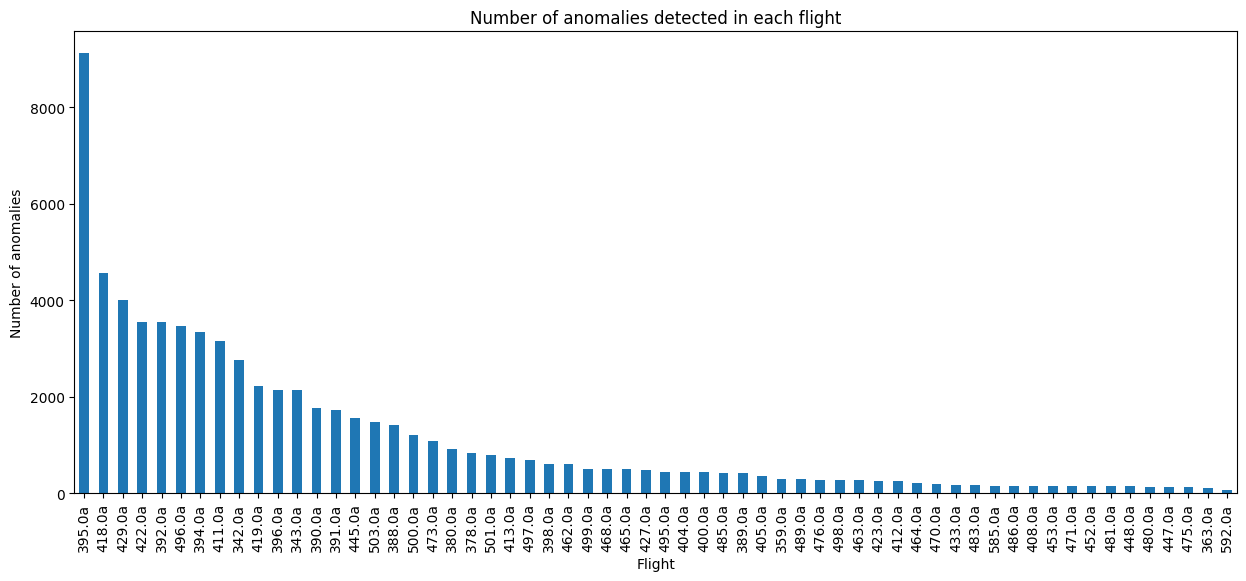

In [ ]:
#plot the flights with most anomalies from higher to lower
anomalies_count.sort_values(ascending=False).plot(kind='bar', figsize=(15, 6))
plt.title('Number of anomalies detected in each flight')
plt.xlabel('Flight')
plt.ylabel('Number of anomalies')
plt.show()



In [ ]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

# Define the grid of hyperparameters
param_grid = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [2, 4, 6, 8],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'subsample': [0.5, 0.7, 0.9],
    'colsample_bytree': [0.5, 0.7, 0.9],
}

# Create a XGBClassifier object
xgb = XGBClassifier()

# Create a GridSearchCV object
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=3, scoring='accuracy', verbose=2, n_jobs=-1)

# Fit the GridSearchCV object to the data
grid_search.fit(train, target_train)

# Print the best parameters
print(grid_search.best_params_)

# Print the best score
print(grid_search.best_score_)

# Predict anomalies
train_x_predictions = grid_search.predict(train)
test_x_predictions = grid_search.predict(test)

# Print the confusion matrix for training data
cm_train = confusion_matrix(target_train, train_x_predictions)
print(cm_train)

# Print the confusion matrix for test data
cm_test = confusion_matrix(target_test, test_x_predictions)
print(cm_test)

# Print the number of anomalies detected in each flight
# Include 'Flight' column when creating anomalies DataFrame
anomalies = error_df[error_df['True_class'] == 1][['Flight', 'True_class']]
anomalies_count = anomalies.groupby('Flight').size()
print(anomalies_count)

#print precision, recall, accuracy and f1 score
accuracy = accuracy_score(test_df['leak'], test_x_predictions)
recall = recall_score(test_df['leak'], test_x_predictions)
precision = precision_score(test_df['leak'], test_x_predictions)
f1 = f1_score(test_df['leak'], test_x_predictions)

#print feature importance
feature_importances = grid_search.best_estimator_.feature_importances_
features = train.columns
feature_importances_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)
print(feature_importances_df)


Fitting 3 folds for each of 576 candidates, totalling 1728 fits


/Users/constantinwiederin/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/constantinwiederin/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/constantinwiederin/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/constantinwiederin/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/constantinwiederin/anaconda3/lib/python3.11/site-pack

[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=2, n_estimators=50, subsample=0.9; total time=   1.3s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=2, n_estimators=50, subsample=0.9; total time=   1.3s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=2, n_estimators=50, subsample=0.5; total time=   1.4s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=2, n_estimators=50, subsample=0.5; total time=   1.4s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=2, n_estimators=50, subsample=0.7; total time=   1.4s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=2, n_estimators=50, subsample=0.7; total time=   1.4s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=2, n_estimators=50, subsample=0.7; total time=   1.5s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=2, n_estimators=50, subsample=0.5; total time=   1.5s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=2, n_estimators=50,